# Chapter 4: building good training sets

## Handling missing values

Let's start by constructing a simple dataset with some missing values.

In [1]:
import pandas as pd
from io import StringIO

csv_data = '''A,B,C,D
1.0,2.0,3.0,4.0
5.0,6.0,,8.0
10.0,11.0,12.0,'''

df = pd.read_csv(StringIO(csv_data))
df

,A,B,C,D
0,1,2,3,4
1,5,6,NaN,8
2,10,11,12,NaN


Pandas' data frame has some helpful methods for seeing which values are null:

In [2]:
df.isnull()

,A,B,C,D
0,False,False,False,False
1,False,False,True,False
2,False,False,False,True


In [3]:
df.isnull().sum()

A    0
B    0
C    1
D    1
dtype: int64

Side note: while our data is in a data frame, we can always get a numpy array out if we'd like to:

In [4]:
df.values

array([[  1.,   2.,   3.,   4.],
       [  5.,   6.,  nan,   8.],
       [ 10.,  11.,  12.,  nan]])

So we can quickly summarize the number of missing values for each feature.

How do we deal with these missing values before passing the data into a model? There are a few options.

### Filtering out missing data

One option is to simply remove columns or rows with missing data. The `dropna` method has several options for choosing when to filter it out:

In [5]:
df.dropna()

,A,B,C,D
0,1,2,3,4


In [6]:
df.dropna(axis=1)

,A,B
0,1,2
1,5,6
2,10,11


In [7]:
df.dropna(subset=['C'])

,A,B,C,D
0,1,2,3,4
2,10,11,12,NaN


Ultimately we'll want a dataset with no missing values. Short of removing every row or column that has a missing value, how else can we massage the data? 

Note: we could do something like remove all rows where the majority of variables are missing using `df.dropna(thresh=3)` and *then* correct the rows with only one or two missing items using another mechanism so as not to throw out too much of our dataset.

### Imputing missing values

The most common way to correct missing data without removing the associated rows is to replace it with the mean value for that variable. pandas makes this easy:

In [8]:
from sklearn.preprocessing import Imputer

imr = Imputer(missing_values='NaN', strategy='mean', axis=0)
imr = imr.fit(df)
imputed_data = imr.transform(df.values)
imputed_data

array([[  1. ,   2. ,   3. ,   4. ],
       [  5. ,   6. ,   7.5,   8. ],
       [ 10. ,  11. ,  12. ,   6. ]])

Other options to choose from are 'median' and 'most_frequent'.

### The estimator API

Note that `Imputer` objects are similar to the models we used for supervized learning in chapter 3: there's a training step and a application step, and the application step can generalize to new data. This means we could massage the data based on means used in our training data set and then use that same massaging applied to the test data set without having to re-fit on the training set.

## Mapping categorical data to numbers

Categorical data, including nominal and ordinal variables, need to be mapped to number before we can fit them using models.


In [9]:
df = pd.DataFrame([['green', 'M', 10.1, 'class1'],
                   ['red', 'L', 13.5, 'class2'],
                   ['blue', 'XL', 15.3, 'class1']])

df.columns = ['color', 'size', 'price', 'classlabel']
df

,color,size,price,classlabel
0,green,M,10.1,class1
1,red,L,13.5,class2
2,blue,XL,15.3,class1


### Hand mapping ordinal data

Only we know what the meaning of the class labels for an ordinal variable like 'size' is, so we can map it out and apply it

In [10]:
size_mapping = {'XL': 3,
                'L': 2,
                'M': 1}

df['size'] = df['size'].map(size_mapping)
df

,color,size,price,classlabel
0,green,1,10.1,class1
1,red,2,13.5,class2
2,blue,3,15.3,class1


### Mapping nominal features

Two options: the first by hand, the second using a built in helper:

In [11]:
import numpy as np

class_mapping = {label: idx for idx, label in enumerate(np.unique(df['classlabel']))}
class_mapping


{'class1': 0, 'class2': 1}

In [12]:
df['classlabel'] = df['classlabel'].map(class_mapping)
df

,color,size,price,classlabel
0,green,1,10.1,0
1,red,2,13.5,1
2,blue,3,15.3,0


In [13]:
from sklearn.preprocessing import LabelEncoder

class_le = LabelEncoder()
y = class_le.fit_transform(df['classlabel'].values)
y

array([0, 1, 0])

### One hot encoding 

Mapping nominal data with more than two possible values to numerical values is not a great idea, as it tells our model that e.g 'blue' is of greater value than 'green' (assuming we mapped red, green, blue to 0, 1, 2).

The way to work around this is to transform the feature into multiple binary features using one hot encoding

In [14]:
pd.get_dummies(df, columns=['color'])

,size,price,classlabel,color_blue,color_green,color_red
0,1,10.1,0,0,1,0
1,2,13.5,1,0,0,1
2,3,15.3,0,1,0,0


## Loading in the wine dataset

In [15]:
df_wine = pd.read_csv('wine.data', header=None)

df_wine.head(3)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185


note that it doesn't have headers, let's fix that

In [16]:
df_wine.columns = ['Class label', 'Alcohol', 'Malic acid', 'Ash',
                   'Alcalinity of ash', 'Magnesium', 'Total phenols',
                   'Flavanoids', 'Nonflavanoid phenols', 'Proanthocyanins',
                   'Color intensity', 'Hue', 'OD280/OD315 of diluted wines',
                   'Proline']
df_wine.head()

,Class label,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280/OD315 of diluted wines,Proline
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


### Splitting into test / training

In [17]:
from sklearn.cross_validation import train_test_split

X, y = df_wine.iloc[:, 1:].values, df_wine.iloc[:, 0].values

X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=0.3, random_state=0)

### Scaling parameters using standardization

In [18]:
from sklearn.preprocessing import StandardScaler

stdsc = StandardScaler()
X_train_std = stdsc.fit_transform(X_train)
X_test_std = stdsc.transform(X_test)

## Selecting meaningful features

### L1 Penalty for sparser feature set

L1 regularization results in sparser weight vectors than L2, and can be helpful in pairing down the model if overfitting is detected via test performance being worse than training performance.

In [19]:
from sklearn.linear_model import LogisticRegression

for penalty in ['l2', 'l1']:
    print("with penalty {}".format(penalty))
    lr = LogisticRegression(penalty=penalty, C=0.1)
    lr.fit(X_train_std, y_train)
    print('Training accuracy:', lr.score(X_train_std, y_train))
    print('Test accuracy:', lr.score(X_test_std, y_test))
    print('Coefficients: {}'.format(lr.coef_[0]))
    print('')

with penalty l2
Training accuracy: 0.983870967742
Test accuracy: 1.0
Coefficients: [ 0.58228361  0.04305595  0.27096654 -0.53333363  0.00321707  0.29820868
  0.48418851 -0.14789735 -0.00451997  0.15005795  0.08295104  0.38799131
  0.80127898]

with penalty l1
Training accuracy: 0.983870967742
Test accuracy: 0.981481481481
Coefficients: [ 0.28007604  0.          0.         -0.02793926  0.          0.
  0.71000808  0.          0.          0.          0.          0.
  1.23655102]



With penalty l2


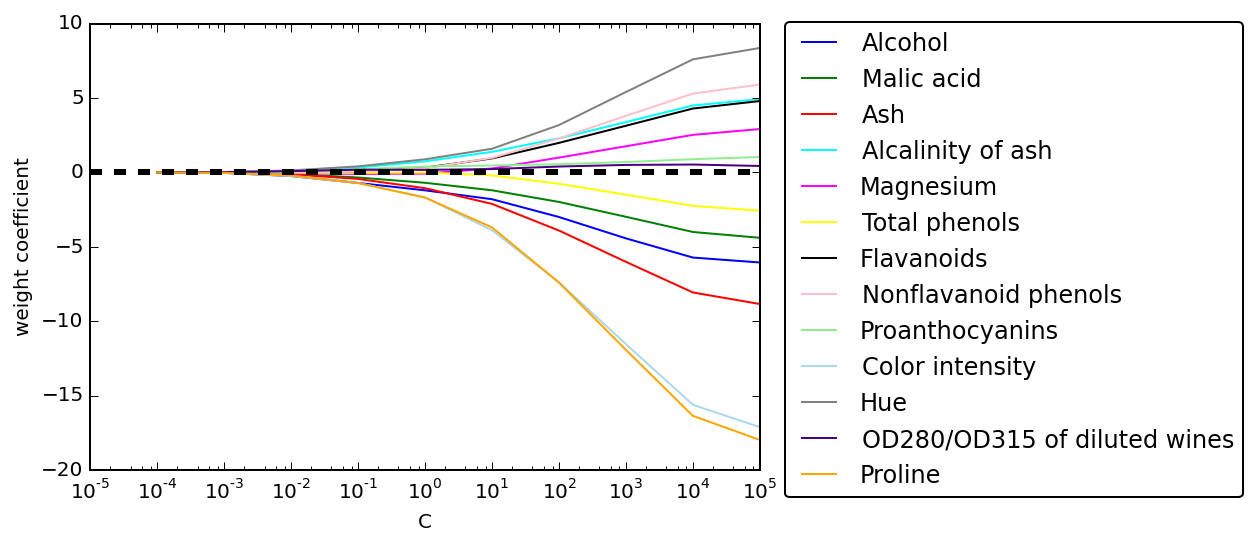

With penalty l1


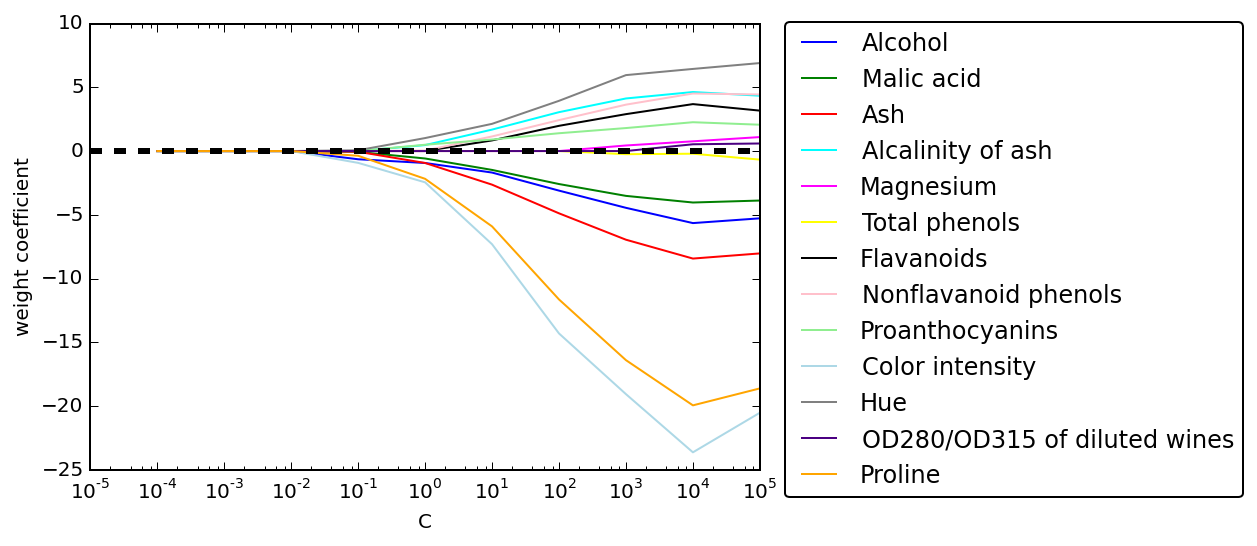

In [21]:
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

for penalty in ['l2', 'l1']:
    print("With penalty {}".format(penalty))

    fig = plt.figure()
    ax = plt.subplot(111)

    colors = ['blue', 'green', 'red', 'cyan', 
              'magenta', 'yellow', 'black', 
              'pink', 'lightgreen', 'lightblue', 
              'gray', 'indigo', 'orange']

    weights, params = [], []
    for c in np.arange(-4, 6):
        lr = LogisticRegression(penalty=penalty, C=10**c, random_state=0)
        lr.fit(X_train_std, y_train)
        weights.append(lr.coef_[1])
        params.append(10**c)

    weights = np.array(weights)

    for column, color in zip(range(weights.shape[1]), colors):
        plt.plot(params, weights[:, column],
                 label=df_wine.columns[column + 1],
                 color=color)
    plt.axhline(0, color='black', linestyle='--', linewidth=3)
    plt.xlim([10**(-5), 10**5])
    plt.ylabel('weight coefficient')
    plt.xlabel('C')
    plt.xscale('log')
    plt.legend(loc='upper left')
    ax.legend(loc='upper center', 
              bbox_to_anchor=(1.38, 1.03),
              ncol=1, fancybox=True)
    plt.show()

Note that with l1 penalty, some of the features drop out more quickly than others, e.g 'magnesium' is down to zero as C gets to 10^4.

## Assessing with the help of Random Forests

 1) Color intensity                0.182508
 2) Proline                        0.158574
 3) Flavanoids                     0.150954
 4) OD280/OD315 of diluted wines   0.131983
 5) Alcohol                        0.106564
 6) Hue                            0.078249
 7) Total phenols                  0.060717
 8) Alcalinity of ash              0.032039
 9) Malic acid                     0.025385
10) Proanthocyanins                0.022369
11) Magnesium                      0.022070
12) Nonflavanoid phenols           0.014655
13) Ash                            0.013933


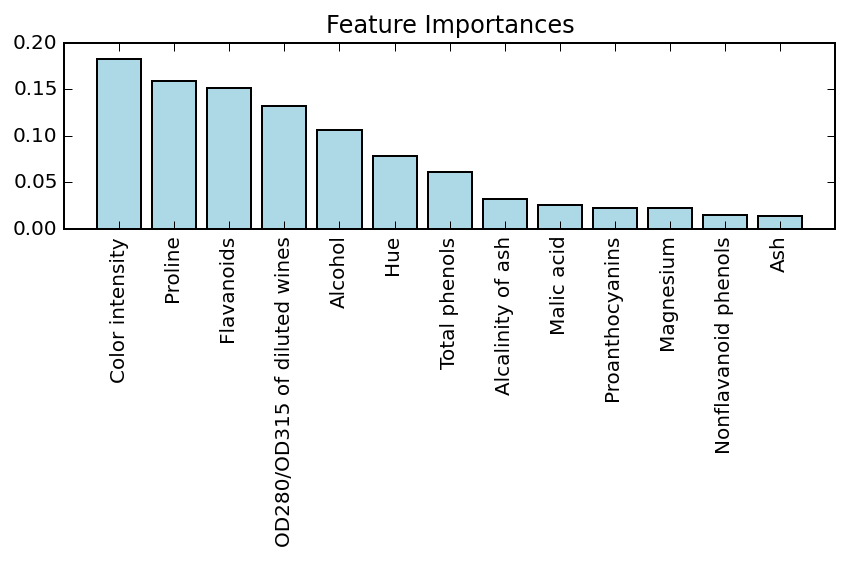

In [22]:
from sklearn.ensemble import RandomForestClassifier

feat_labels = df_wine.columns[1:]

forest = RandomForestClassifier(n_estimators=10000,
                                random_state=0,
                                n_jobs=-1)

forest.fit(X_train, y_train)
importances = forest.feature_importances_

indices = np.argsort(importances)[::-1]

for f in range(X_train.shape[1]):
    print("%2d) %-*s %f" % (f + 1, 30, 
                            feat_labels[indices[f]], 
                            importances[indices[f]]))

plt.title('Feature Importances')
plt.bar(range(X_train.shape[1]), 
        importances[indices],
        color='lightblue', 
        align='center')

plt.xticks(range(X_train.shape[1]), 
           feat_labels[indices], rotation=90)
plt.xlim([-1, X_train.shape[1]])
plt.tight_layout()
#plt.savefig('./random_forest.png', dpi=300)
plt.show()